In [1]:
import random
import itertools

import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import signal
from sklearn import model_selection

In [2]:
def createLSTMLayers(n_layers, n_cells, dropout):
    cell_list = []
    
    for layer in range(n_layers):
        cell = tf.contrib.rnn.LayerNormBasicLSTMCell(n_cells, activation=tf.nn.relu, layer_norm=False)
        
        cell_list.append(cell)
        
    return cell_list

In [3]:
def padSeq(seqs, pad_length, right_pad=True):
    
    '''
    padSeq
    
    Pad sequences to be equal length.
    
    seqs: sequences to be padded
    pad_length: length to pad sequences
    left_pad: Pad at the end of the sequences, or reverse pad from front
    '''
    
    padded_seqs = np.zeros((len(seqs), pad_length))
    
    for idx_row, row in enumerate(seqs):
        for idx_col, col in enumerate(row):
            if right_pad:
                padded_seqs[idx_row, idx_col] = seqs[idx_row][idx_col]
            else:
                padded_seqs[idx_row, pad_length-idx_col-1] = seqs[idx_row][len(row)-idx_col-1]
    return padded_seqs

In [4]:
tf.reset_default_graph()

#Network parameters
encoder_layers = 1
encoder_cells = 6
encoder_dropout = 1

decoder_layers = 1
decoder_cells = 6
decoder_dropout = 1

seq_length = 10
n_features = 1

embedding_dimensions = 13
vocabulary_size = 20
latent_dimensions = 2

#Training Parameters
lr = 0.001
batch_size = 128

In [5]:
inputs = tf.placeholder(name='input', shape=[None, seq_length], dtype=tf.int32)

In [6]:
input_lengths = tf.placeholder(name='input_lengths', shape=[None], dtype=tf.int32)

In [7]:
embedding_matrix = tf.get_variable('embeddings', [vocabulary_size, embedding_dimensions])

In [8]:
embedding_inputs = tf.nn.embedding_lookup(embedding_matrix, inputs)

In [9]:
#encoder
with tf.variable_scope('encoder', reuse=False):
    
    encoder_cell_fw = tf.contrib.rnn.MultiRNNCell(createLSTMLayers(encoder_layers, encoder_cells, encoder_dropout))
    encoder_cell_bw = tf.contrib.rnn.MultiRNNCell(createLSTMLayers(encoder_layers, encoder_cells, encoder_dropout))
    
    (encoder_fw_outputs, encoder_bw_outputs), encoder_state_outputs = tf.nn.bidirectional_dynamic_rnn(
                                        encoder_cell_fw,
                                        encoder_cell_bw, 
                                        inputs=embedding_inputs,
                                        dtype=tf.float32, time_major=False, swap_memory=True)
    
    encoder_final_state = tf.concat([state_tuple[0].h for state_tuple in encoder_state_outputs], axis=1)

In [11]:
latent_vector_in = tf.contrib.layers.fully_connected(encoder_final_state, latent_dimensions, 
                                                     activation_fn=tf.nn.relu,
                                                     normalizer_fn=tf.contrib.layers.batch_norm)

In [12]:
latent_vector_out = tf.contrib.layers.fully_connected(latent_vector_in, decoder_cells, 
                                                      activation_fn=tf.nn.relu,
                                                      normalizer_fn=tf.contrib.layers.batch_norm)

In [13]:
decoder_inputs = tf.zeros([tf.shape(inputs)[0], seq_length, n_features])

In [14]:
decoder_initial_state = tuple([tf.nn.rnn_cell.LSTMStateTuple(c=latent_vector_out, h=latent_vector_out) for i in 
                              range(decoder_layers)])

In [15]:
#decoder

with tf.variable_scope('decoder', reuse=False):
    
    decoder_cell_fw = tf.contrib.rnn.MultiRNNCell(createLSTMLayers(decoder_layers, decoder_cells, decoder_dropout))
    decoder_cell_bw = tf.contrib.rnn.MultiRNNCell(createLSTMLayers(decoder_layers, decoder_cells, decoder_dropout))
    
    (decoder_fw_outputs, decoder_bw_outputs), decoder_state_outputs = tf.nn.bidirectional_dynamic_rnn(
                                        decoder_cell_fw,
                                        decoder_cell_bw, 
                                        inputs=decoder_inputs,
                                        initial_state_fw=decoder_initial_state,
                                        initial_state_bw=decoder_initial_state,
                                        dtype=tf.float32, time_major=False, swap_memory=True)
    
    decoder_outputs = tf.reduce_sum([decoder_fw_outputs, decoder_bw_outputs], axis=0)

In [16]:
#I think what is confusing you here is that the input has to one hot encoded if they categorical!

In [17]:
output_layer = tf.contrib.layers.fully_connected(decoder_outputs, vocabulary_size, activation_fn=tf.nn.relu)

In [18]:
output_probs = tf.contrib.layers.softmax(output_layer)

In [19]:
output_pred = tf.argmax(output_layer, axis=2)

In [20]:
output_probs, output_pred, inputs

(<tf.Tensor 'softmax/Reshape_1:0' shape=(?, 10, 20) dtype=float32>,
 <tf.Tensor 'ArgMax:0' shape=(?, 10) dtype=int64>,
 <tf.Tensor 'input:0' shape=(?, 10) dtype=int32>)

In [21]:
masks = tf.sequence_mask(lengths=input_lengths, maxlen=seq_length, dtype=tf.float32, name='masks')

In [22]:
#Here the inputs can dense as opposed to one hot encoded
#loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=inputs, logits=output_layer)

#try using sequence loss instead

loss = tf.contrib.seq2seq.sequence_loss(logits=output_layer, targets=inputs, weights=masks)

In [23]:
#loss = tf.reduce_sum(tf.square(inputs-output_layer))

In [24]:
optimizer = tf.train.AdamOptimizer(learning_rate=lr).minimize(loss)

In [25]:
signal_types = [signal.exponential, signal.boxcar] 

In [27]:
def generatePseudoSequences(seq_length, low, high, n_seqs, seed, variable_length=False):
    
    '''
    generatePseudoSequences
    
    seq_length: Length of sequence to generate
    low: lower bound of values
    high: upper bound of values
    n_seqs: number of sequences to generate
    variable_length: Create sequence of variable length    
    '''
    random.seed(seed)
    
    #Generate random sequences
    random_seqs = []
    for seq in range(n_seqs):
        if variable_length: current_length = random.randint(1, seq_length)
        else: current_length = seq_length
        current_seq = [random.randint(low, high) for _ in range(current_length)]
        
        random_seqs.append(current_seq)
        
    #Generate repeating sequences    
    repeat_seqs = []
    for seq in range(n_seqs):
        if variable_length: current_length = random.randint(1, seq_length)
        else: current_length = seq_length
        seq_value = random.randint(low, high)
        current_seq = [seq_value for _ in range(current_length)]
        
        repeat_seqs.append(current_seq)
        
    #Generate ascending sequences    
    ascend_seqs = []
    for seq in range(n_seqs):
        if variable_length: current_length = random.randint(1, seq_length)
        else: current_length = seq_length
        seq_value = random.randint(low, high)
        current_seq = [seq_value+i for i in range(0, current_length, 1)]
        
        ascend_seqs.append(current_seq)
    
    #Generate descending sequences
    descend_seqs = []
    for seq in range(n_seqs):
        if variable_length: current_length = random.randint(1, seq_length)
        else: current_length = seq_length
        seq_value = random.randint(low+2, high)
        current_seq = [seq_value-i for i in range(0, current_length, 1)]
        
        descend_seqs.append(current_seq)
    
    #Generate skip sequences
    skip_seqs = []
    for seq in range(n_seqs):
        if variable_length: current_length = random.randint(2, seq_length)
        else: current_length = seq_length
        skip_value = random.randint(1, 5)
        seq_value = random.randint(low, high)
        seq_value = seq_value-skip_value
        current_seq = [seq_value+i*skip_value for i in range(0, current_length, 1)]
        
        skip_seqs.append(current_seq)

    #Generate signal sequences
    sig_seqs = []
    for seq in range(n_seqs):
        #Signal width should not be less then five here
        if variable_length: current_length = random.randint(5, seq_length)
        else: variable_length = max(5, seq_length)
        tau_value = random.random()/variable_length
        signal = random.sample(signal_types, k=1)[0]
        amplitude = random.random()*random.randrange(low, high)
        current_seq = [i*amplitude for i in signal(M=current_length)]        
        sig_seqs.append(current_seq)

        
    #return np.concatenate([descend_seqs, ascend_seqs])
    #return skip_seqs
    #return random_seqs
    return sig_seqs

In [28]:
pseudo_seqs = generatePseudoSequences(seq_length, 1, 10, 50000, 0, variable_length=True)

In [29]:
pseudo_seqs_lengths = [len(i) for i in pseudo_seqs]

In [30]:
df_seqs = pd.DataFrame(padSeq(pseudo_seqs, seq_length))

In [31]:
seq_cols = df_seqs.columns.values

In [32]:
df_seqs['seq_length'] = pseudo_seqs_lengths

In [368]:
#df_seqs['label'] = df_seqs[seq_cols].apply(lambda x:'_'.join([str(i) for i in x]), axis=1)

In [34]:
df_seqs['label'] = df_seqs[1]-df_seqs[0]

In [370]:
#df_seqs['label'] = df_seqs[0].apply(str)

In [35]:
df_seqs = df_seqs.sample(frac=1)

In [37]:
df_seqs

,0,1,2,3,4,5,6,7,8,9,seq_length,label
6336,0.034883,0.094822,0.257752,0.094822,0.034883,0.000000,0.000000,0.000000,0.000000,0.000000,5,0.059939
9485,0.165867,0.450873,1.225600,3.331527,3.331527,1.225600,0.450873,0.165867,0.000000,0.000000,8,0.285006
1,0.005661,0.015389,0.041832,0.113711,0.309098,0.309098,0.113711,0.041832,0.015389,0.005661,10,0.009728
40272,0.126395,0.343577,0.933939,2.538711,6.900931,2.538711,0.933939,0.343577,0.126395,0.000000,9,0.217182
24275,0.003359,0.009130,0.024817,0.067458,0.067458,0.024817,0.009130,0.003359,0.000000,0.000000,8,0.005771
39831,0.261905,0.711930,1.935227,5.260493,1.935227,0.711930,0.261905,0.000000,0.000000,0.000000,7,0.450026
24024,0.094007,0.255537,0.694621,1.888177,5.132596,1.888177,0.694621,0.255537,0.094007,0.000000,9,0.161530
28489,0.002624,0.007131,0.019385,0.052695,0.143240,0.143240,0.052695,0.019385,0.007131,0.002624,10,0.004508
19552,0.191188,0.191188,0.191188,0.191188,0.191188,0.191188,0.191188,0.000000,0.000000,0.000000,7,0.000000
1620,0.369112,1.003351,2.727390,7.413814,2.727390,1.003351,0.369112,0.000000,0.000000,0.000000,7,0.634239


In [373]:
df_train, df_test = model_selection.train_test_split(df_seqs, test_size=0.2)

In [374]:
df_train.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

In [375]:
#training

n_epochs = 10
n_batches = df_train.shape[0]//batch_size

In [376]:
metrics = []
with tf.Session() as sess:
    
    sess.run(tf.global_variables_initializer())
    
    print ('Begin training')
    
    for c_epoch in range(n_epochs):
        df_train_current = df_train.sample(frac=1)
        
        for c_batch in range(n_batches): 
            batch = df_train_current[seq_cols][c_batch*batch_size:(c_batch+1)*batch_size].values
            batch_lengths = df_train_current['seq_length'][c_batch*batch_size:(c_batch+1)*batch_size].values

            #batch = batch.reshape(len(batch), seq_length, 1)
            results = sess.run([optimizer, loss, encoder_final_state, latent_vector_in, latent_vector_out, output_layer], 
                               {inputs:batch, input_lengths:batch_lengths})
            
            
            if c_batch%300==0:
                df_test_current = df_test.sample(n=batch_size)
                test_batch = df_test_current[seq_cols]
                test_batch_lengths = df_test_current['seq_length']
                #test_batch = test_batch.values.reshape(df_test_batch.shape[0], seq_length, 1)
                results_test = sess.run([loss, output_layer], 
                               {inputs:test_batch, input_lengths:test_batch_lengths})            
             
                
                print ('epoch:%d, batch:%d, batch loss:%.3g, test loss:%.3g, norm batch loss:%.3g, norm test loss:%.3g' % 
                       (c_epoch, c_batch, results[1], results_test[0], 
                        results[1]/batch_size, results_test[0]/batch_size))
                
                metrics.append([c_epoch, c_batch, results[1], results_test[0]])
    
        if c_epoch%10==0:
            
            latent_vectors_train = sess.run(latent_vector_in, 
                                      {inputs:df_train[seq_cols].values#.reshape(df_train.shape[0], seq_length, 1)
                                      })
            
            latent_vectors_test = sess.run(latent_vector_in, 
                                      {inputs:df_test[seq_cols].values#.reshape(df_test.shape[0], seq_length, 1)
                                      })
            
            total_output_test = sess.run(output_layer, 
                                         {inputs:df_test[seq_cols].values#.reshape(df_test.shape[0], seq_length, 1)
                                         })

Begin training
epoch:0, batch:0, batch loss:2.22, test loss:2.23, norm batch loss:0.0173, norm test loss:0.0174
epoch:0, batch:300, batch loss:0.764, test loss:0.75, norm batch loss:0.00597, norm test loss:0.00586
epoch:1, batch:0, batch loss:0.732, test loss:0.749, norm batch loss:0.00572, norm test loss:0.00585
epoch:1, batch:300, batch loss:0.643, test loss:0.62, norm batch loss:0.00503, norm test loss:0.00485
epoch:2, batch:0, batch loss:0.626, test loss:0.621, norm batch loss:0.00489, norm test loss:0.00486
epoch:2, batch:300, batch loss:0.595, test loss:0.538, norm batch loss:0.00465, norm test loss:0.0042
epoch:3, batch:0, batch loss:0.562, test loss:0.526, norm batch loss:0.00439, norm test loss:0.00411
epoch:3, batch:300, batch loss:0.498, test loss:0.572, norm batch loss:0.00389, norm test loss:0.00447
epoch:4, batch:0, batch loss:0.549, test loss:0.569, norm batch loss:0.00429, norm test loss:0.00444
epoch:4, batch:300, batch loss:0.5, test loss:0.461, norm batch loss:0.0039

In [377]:
metrics = np.array(metrics)

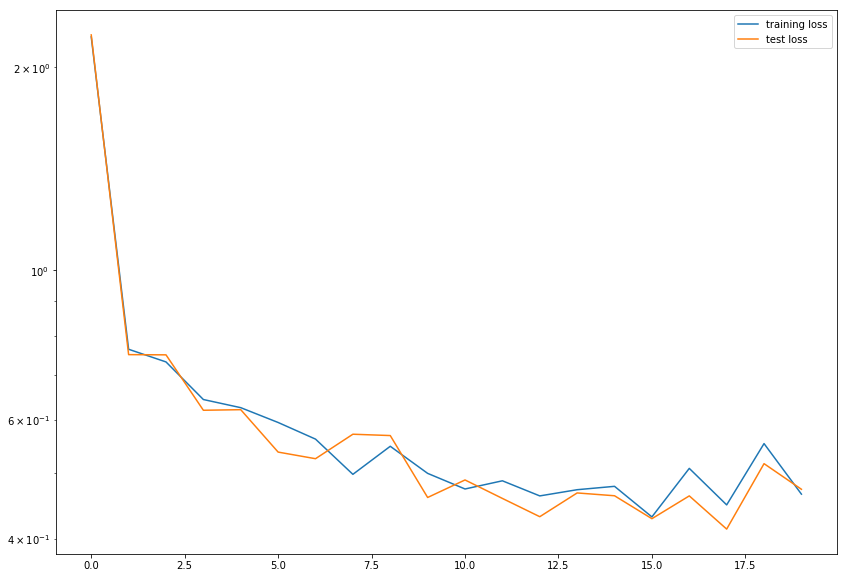

In [378]:
plt.figure(figsize=(14, 10))
plt.semilogy([i for i in range(len(metrics[:,2]))], metrics[:,2], label='training loss')
plt.semilogy([i for i in range(len(metrics[:,3]))], metrics[:,3], label='test loss')
plt.legend(loc='best')
plt.show()

In [379]:
df_vectors = pd.DataFrame(latent_vectors_train, columns=['x', 'y'])

In [380]:
#Join to training data
df_seqs_vectors = df_train.merge(df_vectors, left_index=True, right_index=True)

In [381]:
df_seqs_vectors['label_add'] = df_seqs_vectors[seq_cols].apply(lambda x: '_'.join([str(i) for i in x]), axis=1)

In [382]:
#df_seqs_vectors['label_add'] = df_seqs_vectors['label'].apply(str) + df_seqs_vectors[0].apply(str)

In [383]:
df_seqs_vectors[df_seqs_vectors[0]==3].head()

,0,1,2,3,4,seq_length,label,x,y,label_add
0,3.0,2.0,3.0,1.0,2.0,5,3.0,0.000000,0.731102,3.0_2.0_3.0_1.0_2.0
1,3.0,2.0,1.0,0.0,0.0,3,3.0,0.257457,0.522794,3.0_2.0_1.0_0.0_0.0
4,3.0,1.0,0.0,0.0,0.0,2,3.0,0.000000,0.172929,3.0_1.0_0.0_0.0_0.0
9,3.0,3.0,3.0,1.0,1.0,5,3.0,0.000000,0.503041,3.0_3.0_3.0_1.0_1.0
11,3.0,3.0,3.0,2.0,3.0,5,3.0,0.000000,0.977251,3.0_3.0_3.0_2.0_3.0


In [384]:
label_col = 'label_add'

In [385]:
unique_seqs = df_seqs_vectors[label_col].unique()

In [386]:
len(unique_seqs)

363

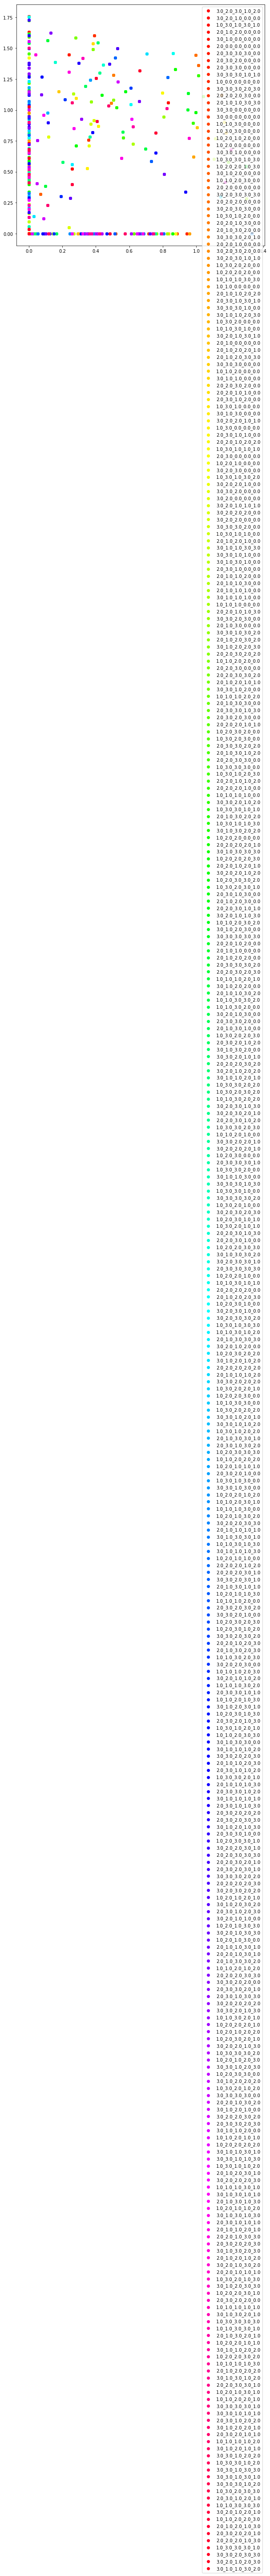

In [387]:
#Analysis

plt.figure(1, figsize=(10, 10))
cmap = plt.cm.get_cmap('hsv', len(unique_seqs)+1)
for idx_seq, seq in enumerate(unique_seqs):
    df_current = df_seqs_vectors[df_seqs_vectors[label_col]==seq]
    plt.scatter(df_current['x'].values, df_current['y'].values, color=cmap(idx_seq), label=seq)

plt.legend(loc='best')
plt.show()